In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)

def show_tables():
    print('Tables in chinook.db:')
    print(run_query('SELECT name FROM sqlite_master WHERE type="table"'))

show_tables()

Tables in chinook.db:
              name
0            album
1           artist
2         customer
3         employee
4            genre
5          invoice
6     invoice_line
7       media_type
8         playlist
9   playlist_track
10           track


                    total_sold  percent_sold
genre                                       
Rock                      2635      0.553921
Jazz                       121      0.025436
Metal                      619      0.130124
Alternative & Punk         492      0.103427
Blues                      124      0.026067
Latin                      167      0.035106
Reggae                      35      0.007358
Pop                         63      0.013244
Soundtrack                   5      0.001051
Easy Listening              74      0.015556
Heavy Metal                  8      0.001682
R&B/Soul                   159      0.033424
Electronica/Dance           55      0.011562
Hip Hop/Rap                 33      0.006937
TV Shows                     2      0.000420
Drama                        1      0.000210
Alternative                117      0.024595
Classical                   47      0.009880


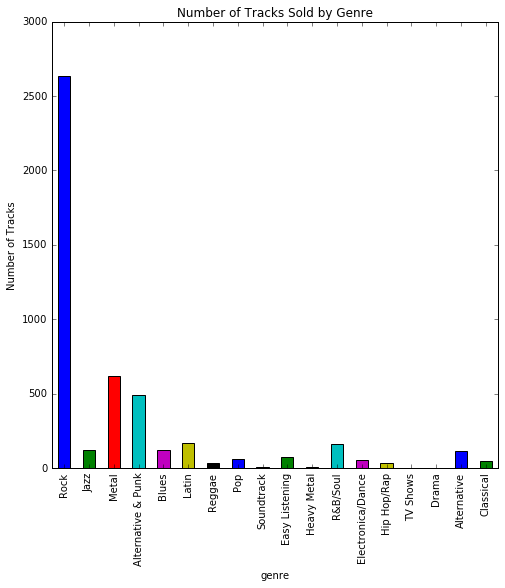

In [3]:
genre_query = """WITH
                     track_quant as (SELECT track_id, SUM(quantity) quantity FROM invoice_line
                                     GROUP BY 1),
                     genre_quant as (SELECT trk.genre_id, SUM(tkq.quantity) quantity
                                     FROM track_quant tkq
                                     INNER JOIN track trk ON trk.track_id = tkq.track_id
                                     GROUP BY 1)
                 SELECT gen.name genre, gnq.quantity total_sold, CAST(gnq.quantity AS float) / (SELECT SUM(quantity) FROM genre_quant) percent_sold
                 FROM genre_quant gnq
                 INNER JOIN genre gen ON gnq.genre_id = gen.genre_id;"""
genre_result = run_query(genre_query)
genre_result.set_index('genre', drop=True, inplace=True)
print(genre_result)
plt.figure(figsize=(8,8))
genre_result['total_sold'].plot.bar()
plt.title('Number of Tracks Sold by Genre')
plt.ylabel('Number of Tracks')

This is the markdown cell interpreting the data above and making a recommendation for the three artists whose albums we should purchase for the store, based on sales of tracks from their genres.

                            hire_date  total_sales
employee_name                                     
Andrew Adams      2016-08-14 00:00:00          NaN
Jane Peacock      2017-04-01 00:00:00      1731.51
Laura Callahan    2017-03-04 00:00:00          NaN
Margaret Park     2017-05-03 00:00:00      1584.00
Michael Mitchell  2016-10-17 00:00:00          NaN
Nancy Edwards     2016-05-01 00:00:00          NaN
Robert King       2017-01-02 00:00:00          NaN
Steve Johnson     2017-10-17 00:00:00      1393.92


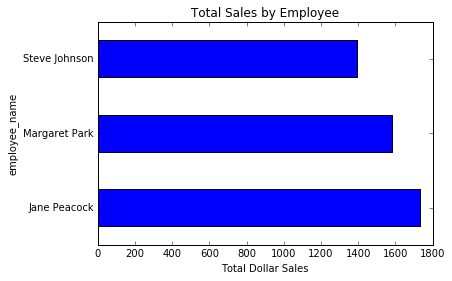

In [4]:
sales_query = """WITH
                     cust_totals AS (SELECT c.support_rep_id, SUM(i.total) total
                                     FROM customer c
                                     LEFT JOIN invoice i ON c.customer_id = i.customer_id
                                     GROUP BY 1)
                 SELECT
                     emp.first_name || ' ' || emp.last_name employee_name,
                     emp.hire_date,
                     SUM(cus.total) total_sales
                 FROM employee emp
                 LEFT JOIN cust_totals cus ON cus.support_rep_id = emp.employee_id
                 GROUP BY 1;"""
sales_result = run_query(sales_query)
sales_result.set_index('employee_name', drop=True, inplace=True)
print(sales_result)
plt.figure(figsize=(4,8))
sales_result.dropna().plot.barh(legend=False)
plt.title('Total Sales by Employee')
plt.xlabel('Total Dollar Sales')

This is the markdown cell describing the results and suggesting that total sales must be adjusted by hiring date before comparing.

In [34]:
country_query = """WITH
                       country_custs AS (SELECT country, COUNT(customer_id) count FROM customer
                                         GROUP BY 1
                                         HAVING COUNT(customer_id) > 1),
                       country_values AS (SELECT cus.country, cnc.count, SUM(inv.total) total_inv, AVG(inv.total) avg_inv FROM customer cus
                                          LEFT JOIN invoice inv ON cus.customer_id = inv.customer_id
                                          INNER JOIN country_custs cnc ON cus.country = cnc.country
                                          GROUP BY 1),
                       country_others AS (SELECT country, COUNT(customer_id) count, customer_id FROM customer
                                          GROUP BY 1
                                          HAVING COUNT(customer_id) == 1),
                       other_sales AS (SELECT cno.country, SUM(inv.total) total, AVG(inv.total) average FROM country_others cno
                                       LEFT JOIN invoice inv ON cno.customer_id = inv.customer_id
                                       GROUP BY 1),
                       other_values AS (SELECT "Other" country, COUNT(cno.country) customer_count, ots.total total_sales, CAST(ots.total AS float) / COUNT(cno.country), ots.average average_order_value
                                        FROM country_others cno
                                        INNER JOIN other_sales ots ON cno.country = ots.country
                                        GROUP BY 1)
                   SELECT country, count customer_count, total_inv total_sales, CAST(total_inv AS float) / count average_sales_per_customer, avg_inv average_order_value
                   FROM country_values
                   UNION
                   SELECT * FROM other_values
                   ORDER BY 3 DESC;"""
country_sales = run_query(country_query)
country_sales.set_index('country', inplace=True, drop=True)
print(country_sales)

                customer_count  total_sales  average_sales_per_customer  \
country                                                                   
USA                         13      1040.49                   80.037692   
Canada                       8       535.59                   66.948750   
Brazil                       5       427.68                   85.536000   
France                       5       389.07                   77.814000   
Germany                      4       334.62                   83.655000   
Czech Republic               2       273.24                  136.620000   
United Kingdom               3       245.52                   81.840000   
Portugal                     2       185.13                   92.565000   
India                        2       183.15                   91.575000   
Other                       15        75.24                    5.016000   

                average_order_value  
country                              
USA                    

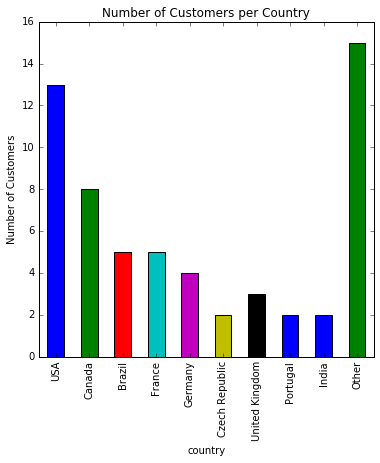

In [36]:
plt.figure(figsize=(6,6))
country_sales['customer_count'].plot.bar()
plt.title('Number of Customers per Country')
plt.ylabel('Number of Customers')

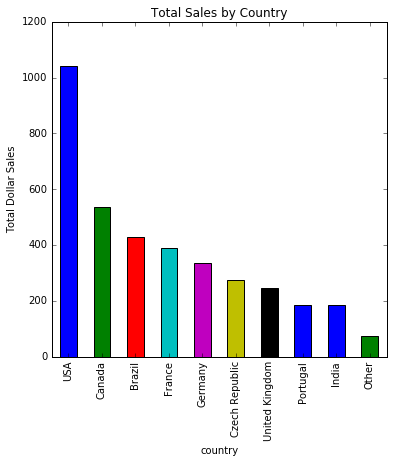

In [37]:
plt.figure(figsize=(6,6))
country_sales['total_sales'].plot.bar()
plt.title('Total Sales by Country')
plt.ylabel('Total Dollar Sales')

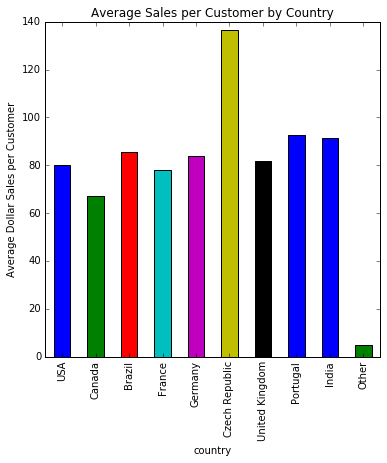

In [38]:
plt.figure(figsize=(6,6))
country_sales['average_sales_per_customer'].plot.bar()
plt.title('Average Sales per Customer by Country')
plt.ylabel('Average Dollar Sales per Customer')

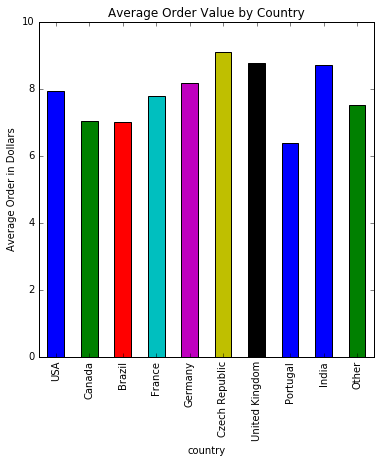

In [39]:
plt.figure(figsize=(6,6))
country_sales['average_order_value'].plot.bar()
plt.title('Average Order Value by Country')
plt.ylabel('Average Order in Dollars')

This is the markdown cell interpreting the data and visualizations above and making recommendations to the marketing team on which countries have the potential for growth.

In [51]:
album_query = """WITH
                     all_lines AS (SELECT inl.invoice_id, inl.track_id, trk.album_id FROM invoice_line inl
                                   LEFT JOIN track trk ON inl.track_id = trk.track_id),
                     last_lines AS (SELECT * FROM all_lines
                                    GROUP BY 1),
                     invoice_albums AS (SELECT lal.invoice_id, ((SELECT track_id FROM all_lines WHERE invoice_id = lal.invoice_id
                                                                 EXCEPT
                                                                 SELECT track_id FROM track WHERE album_id = lal.album_id) IS NULL
                                                                 AND
                                                                (SELECT track_id FROM track WHERE album_id = lal.album_id
                                                                EXCEPT
                                                                SELECT track_id FROM all_lines WHERE invoice_id = lal.invoice_id) IS NULL
                                                               ) is_album FROM last_lines lal)
                     SELECT COUNT(invoice_id) album_count, is_album, CAST(COUNT(invoice_id) AS float) / (SELECT COUNT(*) FROM invoice_albums) percentage
                     FROM invoice_albums
                     GROUP BY 2;"""
test_query = """WITH
                     all_lines AS (SELECT inl.invoice_id, inl.track_id, trk.album_id FROM invoice_line inl
                                   LEFT JOIN track trk ON inl.track_id = trk.track_id),
                     last_lines AS (SELECT * FROM all_lines
                                    GROUP BY 1)
"""
#print(run_query(test_query))
print(run_query(album_query))

   album_count  is_album  percentage
0          500         0    0.814332
1          114         1    0.185668


This is one to two sentences explaining my findings and making a prospective recommendation on whether the Chin